In [1]:
import pandas as pd
import numpy as np
import pickle
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Data Loading

In [2]:
chicago_crime = pickle.load(open('./data/chicago_crime.pickle', 'rb'))

In [3]:
chicago_crime_init = chicago_crime.copy()

In [4]:
chicago_crime.head()

,Date,Primary Type,Description,Location Description,Arrest,Domestic,Community Area,Year,Latitude,Longitude,Hour,Day,Month
60345,2019-01-03 19:00:00,PUBLIC PEACE VIOLATION,OTHER VIOLATION,AIRCRAFT,False,False,76,2019,42.002816,-87.906094,19,3,1
62272,2019-03-16 18:00:00,BATTERY,SIMPLE,STREET,False,False,32,2019,41.883369,-87.633860,18,16,3
62615,2019-03-12 22:00:00,THEFT,$500 AND UNDER,RESIDENTIAL YARD (FRONT/BACK),False,False,36,2019,41.825347,-87.606781,22,12,3
62648,2019-03-14 19:00:00,BATTERY,SIMPLE,RESIDENCE,False,False,1,2019,42.016542,-87.672499,19,14,3
62649,2019-03-14 16:00:00,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,True,36,2019,41.825299,-87.606961,16,14,3


In [5]:
chicago_crime.shape

(6944360, 13)

# Feature cleaning/eng

In [6]:
from fastai.tabular import add_datepart
import seaborn as sns
import matplotlib.pyplot as plt

Let's first see if we still have missing data

In [7]:
chicago_crime.isnull().mean()

Date                    0.000000
Primary Type            0.000000
Description             0.000000
Location Description    0.000000
Arrest                  0.000000
Domestic                0.000000
Community Area          0.087011
Year                    0.000000
Latitude                0.000000
Longitude               0.000000
Hour                    0.000000
Day                     0.000000
Month                   0.000000
dtype: float64

Only the community area has some missing values, as it is only a small portion of the dataset we will simply disregard the rows with missing value

In [8]:
chicago_crime = chicago_crime[chicago_crime.notna().all(1)]

In [9]:
chicago_crime.isnull().sum()

Date                    0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Community Area          0
Year                    0
Latitude                0
Longitude               0
Hour                    0
Day                     0
Month                   0
dtype: int64

- **Date**

The information about the date and time is already in other columns so we can remove the Date column

In [10]:
chicago_crime.drop(columns='Date', inplace=True)

- **Primary Type**

In [11]:
p_type = chicago_crime['Primary Type']

In [12]:
p_type.nunique()

34

In [13]:
p_type_vc = p_type.value_counts()
p_type_vc

THEFT                                1344440
BATTERY                              1159460
CRIMINAL DAMAGE                       724093
NARCOTICS                             649432
ASSAULT                               398093
OTHER OFFENSE                         393281
BURGLARY                              364091
MOTOR VEHICLE THEFT                   288011
DECEPTIVE PRACTICE                    253592
ROBBERY                               239517
CRIMINAL TRESPASS                     182296
WEAPONS VIOLATION                      71076
PROSTITUTION                           60505
PUBLIC PEACE VIOLATION                 45788
OFFENSE INVOLVING CHILDREN             42838
CRIM SEXUAL ASSAULT                    25313
SEX OFFENSE                            22626
INTERFERENCE WITH PUBLIC OFFICER       16103
GAMBLING                               13351
LIQUOR LAW VIOLATION                   12186
ARSON                                  10149
HOMICIDE                                9595
KIDNAPPING

We can first regroup some types that are similar

In [14]:
similar_types = {'NARCOTICS' : ['NARCOTICS', 'OTHER NARCOTIC VIOLATION'], 'SEXUAL CRIME' : ['SEX OFFENSE', 'CRIM SEXUAL ASSAULT', 'PROSTITUTION'], 'PUBLIC PEACE VIOLATION' : ['OBSCENITY', 'PUBLIC INDECENCY']}
type_to_group ={e : v for v in similar_types for e in similar_types[v]}

In [15]:
chicago_crime['Primary Type'].replace(type_to_group, inplace=True)

In [16]:
p_type_vc = p_type.value_counts()
p_type_vc

THEFT                                1344440
BATTERY                              1159460
CRIMINAL DAMAGE                       724093
NARCOTICS                             649550
ASSAULT                               398093
OTHER OFFENSE                         393281
BURGLARY                              364091
MOTOR VEHICLE THEFT                   288011
DECEPTIVE PRACTICE                    253592
ROBBERY                               239517
CRIMINAL TRESPASS                     182296
SEXUAL CRIME                          108444
WEAPONS VIOLATION                      71076
PUBLIC PEACE VIOLATION                 46535
OFFENSE INVOLVING CHILDREN             42838
INTERFERENCE WITH PUBLIC OFFICER       16103
GAMBLING                               13351
LIQUOR LAW VIOLATION                   12186
ARSON                                  10149
HOMICIDE                                9595
KIDNAPPING                              5628
INTIMIDATION                            3718
STALKING  

Some types have too low frequency to be of use in our future models. To address thid issue, we simply regroup the low frequency types in the type : 'OTHER OFFENSE'

In [17]:
def regroup_low_fred(data, column, min_freq, name='OTHER') :
    freq = data[column].value_counts()
    lowf_types = list(freq[freq <min_freq].index)
    data[column] = data[column].apply(lambda x : name if x in lowf_types else x)

In [18]:
regroup_low_fred(chicago_crime, 'Primary Type', 10000, 'OTHER OFFENSE')

In [19]:
chicago_crime['Primary Type'].value_counts()

THEFT                               1344440
BATTERY                             1159460
CRIMINAL DAMAGE                      724093
NARCOTICS                            649550
OTHER OFFENSE                        416298
ASSAULT                              398093
BURGLARY                             364091
MOTOR VEHICLE THEFT                  288011
DECEPTIVE PRACTICE                   253592
ROBBERY                              239517
CRIMINAL TRESPASS                    182296
SEXUAL CRIME                         108444
WEAPONS VIOLATION                     71076
PUBLIC PEACE VIOLATION                46535
OFFENSE INVOLVING CHILDREN            42838
INTERFERENCE WITH PUBLIC OFFICER      16103
GAMBLING                              13351
LIQUOR LAW VIOLATION                  12186
ARSON                                 10149
Name: Primary Type, dtype: int64

- **Description**

In [20]:
chicago_crime['Description'].nunique()

378

In [21]:
chicago_crime['Description'].value_counts()

SIMPLE                                          697667
DOMESTIC BATTERY SIMPLE                         539453
$500 AND UNDER                                  490446
TO VEHICLE                                      350456
TO PROPERTY                                     330926
OVER $500                                       319577
POSS: CANNABIS 30GMS OR LESS                    256654
FORCIBLE ENTRY                                  244762
FROM BUILDING                                   235493
AUTOMOBILE                                      227583
RETAIL THEFT                                    177448
TELEPHONE THREAT                                124703
TO LAND                                         111883
POSS: CRACK                                     101271
UNLAWFUL ENTRY                                   98411
HARASSMENT BY TELEPHONE                          90845
ARMED: HANDGUN                                   85009
POSS: HEROIN(WHITE)                              83877
STRONGARM 

Regroup low freqeuncy again 

In [ ]:
regroup_low_fred(chicago_crime, 'Description', 10000)

In [ ]:
chicago_crime['Description'].nunique()

In [ ]:
chicago_crime['Description'].value_counts()

- **Local Description**


In [ ]:
chicago_crime['Location Description'].nunique()

In [ ]:
chicago_crime['Location Description'].value_counts()

Regroup low frequency

In [ ]:
regroup_low_fred(chicago_crime, 'Location Description', 10000 )

In [ ]:
chicago_crime['Location Description'].nunique()

In [ ]:
chicago_crime['Location Description'].value_counts()

In [ ]:
#pickle.dump(chicago_crime, open('data/chicago_crimes_processing.pkl', 'wb'))

In [2]:
chicago_crime = pickle.load(open('data/chicago_crimes_processing.pkl', 'rb'))

# Data prep

In [3]:
chicago_crime.head()

,Primary Type,Description,Location Description,Arrest,Domestic,Community Area,Year,Latitude,Longitude,Hour,Day,Month
60345,PUBLIC PEACE VIOLATION,OTHER,OTHER,False,False,76,2019,42.002816,-87.906094,19,3,1
62272,BATTERY,SIMPLE,STREET,False,False,32,2019,41.883369,-87.633860,18,16,3
62615,THEFT,$500 AND UNDER,RESIDENTIAL YARD (FRONT/BACK),False,False,36,2019,41.825347,-87.606781,22,12,3
62648,BATTERY,SIMPLE,RESIDENCE,False,False,1,2019,42.016542,-87.672499,19,14,3
62649,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,True,36,2019,41.825299,-87.606961,16,14,3


In [8]:
from fastai.tabular.data import TabularProc
from pandas import DataFrame

For categorical variables to be usable in a model, we need to numericalize it

In [9]:
class myCategorify(TabularProc):
    "Transform the categorical variables to that type."
    def apply_train(self, df:DataFrame):
        "Transform `self.cat_names` columns in categorical."
        self.categories = {}
        for n in self.cat_names:
            df.loc[:,n] = df.loc[:,n].astype('category').cat.as_ordered()
            self.categories[n] = df[n].cat.categories

    def apply_test(self, df:DataFrame):
        "Transform `self.cat_names` columns in categorical using the codes decided in `apply_train`."
        for n in self.cat_names:
            if n in df.columns :
                df.loc[:,n] = pd.Categorical(df[n], categories=self.categories[n], ordered=True)

In [10]:
cat_vars = ['Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Community Area']
cont_vars = ['Year', 'Latitude', 'Longitude', 'Hour', 'Day', 'Month']

In [11]:
cat_proc = myCategorify(cat_vars, cont_vars)

In [12]:
cat_proc(chicago_crime)

In [13]:
for c in cat_vars :
    chicago_crime[c] = chicago_crime[c].cat.codes

For some models we also need to normalize numerical data

In [18]:
class my_Normalize(TabularProc):
    "Normalize the continuous variables."
    def apply_train(self, df:DataFrame):
        "Comput the means and stds of `self.cont_names` columns to normalize them."
        self.means,self.stds = {},{}
        for n in self.cont_names:
            self.means[n],self.stds[n] = df.loc[:,n].mean(),df.loc[:,n].std()
            df.loc[:,n] = (df.loc[:,n]-self.means[n]) / (1e-7 + self.stds[n])

    def apply_test(self, df:DataFrame):
        "Normalize `self.cont_names` with the same statistics as in `apply_train`."
        for n in self.cont_names:
            if n in df.columns :
                df.loc[:,n] = (df.loc[:,n]-self.means[n]) / (1e-7 + self.stds[n])


In [19]:
norm_proc = my_Normalize(cat_vars, cont_vars)

In [20]:
norm_proc(chicago_crime)

In [111]:
#pickle.dump((cat_proc, norm_proc), open('data/data_processors.pkl', 'wb'))

In [22]:
#pickle.dump((chicago_crime, cat_proc, norm_proc), open('data/chicago_crimes_processing_data.pkl', 'wb'))

In [23]:
chicago_crime, cat_proc, norm_proc = pickle.load(open('data/chicago_crimes_processing_data.pkl', 'rb'))

In [4]:
chicago_crime.head()

,Primary Type,Description,Location Description,Arrest,Domestic,Community Area,Year,Latitude,Longitude,Hour,Day,Month
60345,14,39,26,0,0,76,1.918047,1.863753,-3.962305,0.860247,-1.432802,-1.701383
62272,2,52,40,0,0,32,1.918047,0.480551,0.640177,0.713617,0.038834,-1.095794
62615,17,0,33,0,0,36,1.918047,-0.191352,1.097996,1.300135,-0.413977,-1.095794
62648,2,52,30,0,0,1,1.918047,2.022692,-0.013068,0.860247,-0.187572,-1.095794
62649,13,40,40,0,1,36,1.918047,-0.191911,1.094947,0.420358,-0.187572,-1.095794


# Arrest prediction

Our first model we want to build is a model that predicts wether the culprit of a crime will be arrested or not, so we want to predict the arrest column given all the pther columns.

Let's look at the distribution of the arrests

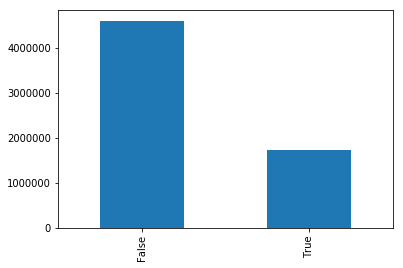

In [50]:
chicago_crime['Arrest'].map({1 : 'True', 0: 'False'}).value_counts().plot(kind='bar')
plt.show()

We can see taht the data is not very well balance, we will focus on the f1 score as the metric.

## Splitting data

We first need to split the depend variable 'Arrest' and the other independent variables. For testing models, we should use a sample of the dataset as the full dataset is too large.

In [24]:
def get_sample(X, y,pctg=0.1) :
    permu = np.random.permutation(X.shape[0])
    idxs = permu[:int(pctg*X.shape[0])]
    return X.iloc[idxs], y.iloc[idxs]

In [6]:
indep_vars = ['Primary Type', 'Description', 'Location Description',
       'Domestic', 'Year', 'Latitude', 'Longitude', 'Hour', 'Community Area',
       'Day', 'Month']
dep_var = 'Arrest'

In [7]:
X, y = chicago_crime[indep_vars], chicago_crime[dep_var]

In [8]:
X.head()

,Primary Type,Description,Location Description,Domestic,Year,Latitude,Longitude,Hour,Community Area,Day,Month
60345,14,39,26,0,1.918047,1.863753,-3.962305,0.860247,76,-1.432802,-1.701383
62272,2,52,40,0,1.918047,0.480551,0.640177,0.713617,32,0.038834,-1.095794
62615,17,0,33,0,1.918047,-0.191352,1.097996,1.300135,36,-0.413977,-1.095794
62648,2,52,30,0,1.918047,2.022692,-0.013068,0.860247,1,-0.187572,-1.095794
62649,13,40,40,1,1.918047,-0.191911,1.094947,0.420358,36,-0.187572,-1.095794


In [9]:
X_sample, y_sample = get_sample(X, y, pctg=0.1)

We can now split the data between training and validation set

In [25]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.1)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((570610, 11), (63402, 11), (570610,), (63402,))

In [13]:
X_train.head()

,Primary Type,Description,Location Description,Domestic,Year,Latitude,Longitude,Hour,Community Area,Day,Month
4033626,13,32,30,0,-0.688687,0.983749,-1.491142,1.006876,19,1.057659,1.326559
2939201,2,20,3,1,-1.089723,1.505672,-0.939695,-1.485826,14,0.604848,-0.187412
2829175,5,61,26,0,-1.089723,-0.403683,0.827597,0.860247,38,1.510470,-1.095794
3989176,11,43,36,0,-0.688687,1.717189,-0.931605,-1.925715,13,0.718050,0.418176
3666717,17,29,24,0,-0.688687,0.463455,-1.130279,1.006876,26,0.038834,-1.701383


## Models

We will use three diffrent models for modeling :

- Random forest
- XGB 
- FeedForward neural network

Here is a method that will print the sccore on our first two types of model

In [26]:
from sklearn.metrics import f1_score

In [9]:
def print_score(model, f1_average='binary') :
    train_acc = model.score(X_train, y_train)
    valid_acc = model.score(X_test, y_test)
    train_f1 = f1_score(model.predict(X_train), y_train, average=f1_average)
    valid_f1 = f1_score(model.predict(X_test), y_test, average=f1_average)
    print("Train accuray : {:.3f}, Valid accuracy : {:.3f}, Train F1 score : {:.3f}, Valid F1 score : {:.3f}".format(train_acc, valid_acc, train_f1, valid_f1))

### Ranfom forest

We can use the implementation of random forest from sklearn

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [99]:
rf = RandomForestClassifier(n_jobs=-1)

In [100]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [101]:
print_score(rf)

Train accuray : 0.987, Valid accuracy : 0.879, Train F1 score : 0.975, Valid F1 score : 0.746


In [67]:
#pickle.dump(rf, open('data/randomforest_sample.pkl', 'wb'))

### XBG (boosting)

In [28]:
from xgboost import XGBClassifier

In [69]:
xg = XGBClassifier(n_jobs=-1)

In [70]:
xg.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='logloss', early_stopping_rounds=50, verbose=True)

[0]	validation_0-logloss:0.648246
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.611643
[2]	validation_0-logloss:0.581477
[3]	validation_0-logloss:0.551945
[4]	validation_0-logloss:0.527397
[5]	validation_0-logloss:0.506415
[6]	validation_0-logloss:0.490031
[7]	validation_0-logloss:0.474259
[8]	validation_0-logloss:0.460983
[9]	validation_0-logloss:0.449323
[10]	validation_0-logloss:0.439969
[11]	validation_0-logloss:0.431652
[12]	validation_0-logloss:0.424169
[13]	validation_0-logloss:0.41777
[14]	validation_0-logloss:0.409283
[15]	validation_0-logloss:0.401469
[16]	validation_0-logloss:0.395905
[17]	validation_0-logloss:0.39167
[18]	validation_0-logloss:0.389519
[19]	validation_0-logloss:0.386133
[20]	validation_0-logloss:0.382986
[21]	validation_0-logloss:0.381451
[22]	validation_0-logloss:0.378527
[23]	validation_0-logloss:0.37671
[24]	validation_0-logloss:0.372627
[25]	validation_0-logloss:0.371547
[26]	validation_0-logloss:0.369483


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [71]:
print_score(xg)

Train accuray : 0.875, Valid accuracy : 0.875, Train F1 score : 0.728, Valid F1 score : 0.730


In [72]:
#pickle.dump(xg, open('data/xgb_sample.pkl', 'wb'))

### FeedForward neural net

In [29]:
import torch
from torch.nn import Linear, Embedding, Softmax, Dropout, BatchNorm1d, Module, ModuleList, Sequential
from torch.optim import Adam
from tqdm import tqdm_notebook
from fastai.layers import CrossEntropyFlat
from torch.utils.data import TensorDataset, DataLoader

#### Model

In [30]:
class LinearClassifier(Module) :
    """
    Arguments :
        - n_cont : number of continuous features
        - cat_sizes : list of the cardinality of each categorical features
        - emb_sizes : the size of the embeddinbg vector for each categorical variables
        - layers_sizes : the sizes of the hidden layers
        - out_sz : the size of the output layer (cardinality of the class to predict)
        - p_dropout : list of the dropout probabilites for each layer
    """
    
    def __init__(self, n_cont, cat_sizes, emb_sizes, layers_sizes, out_sz, p_dropout) :
        super().__init__()
        self.n_cats = len(cat_sizes)
        self.n_cont = n_cont
        self.n_layers = len(layers_sizes)
        self.embeds = ModuleList([Embedding(c, e) for c, e in zip(cat_sizes, emb_sizes)])
        in_size = sum(e for e in emb_sizes) + self.n_cont
        self.in_size = in_size
        layers = []
        for i, l in enumerate(layers_sizes) :
            if i == 0 :
                layers.append(BatchNorm1d(in_size))
                layers.append(Dropout(p_dropout[i]))
                layers.append(Linear(in_size, l))
            else :
                layers.append(BatchNorm1d(layers_sizes[i-1]))
                layers.append(Dropout(p_dropout[i]))
                layers.append(Linear(layers_sizes[i-1], layers_sizes[i]))
        
        layers.append(BatchNorm1d(layers_sizes[-1]))
        layers.append(Dropout(p_dropout[-1]))
        layers.append(Linear(layers_sizes[-1], out_sz))
        self.layers = Sequential(*layers)
        
    def forward(self, x_cat, x_cont) :
        if x_cat.shape[1] != self.n_cats :
            raise ValueError(f'The number of categorical variables should be {self.n_cats}')
        if x_cont.shape[1] != self.n_cont :
            raise ValueError(f'The number of continious variables should be {self.n_cont}')    
        x_cat_embedded = [self.embeds[i](x_cat[:, i]) for i in range(self.n_cats)]
        x_cat_embedded = torch.cat(x_cat_embedded, dim=1)
        x_full = torch.cat([x_cat_embedded, x_cont], dim=1)
        output = self.layers(x_full)
        return output

#### Training loop

In [31]:
def fit(epochs, model, train_dl, valid_dl, lr=0.01, wd=0, loss_func=CrossEntropyFlat(), cuda=True, f1_average='binary') :
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd)
    
    train_acc, train_f1, train_loss = 0, 0, 0
    valid_acc, valid_f1, valid_loss = 0, 0, 0
    
    if cuda : 
        model = model.cuda()
    
    for epoch in range(epochs) :
        batches_train = tqdm_notebook(train_dl, leave=False,
                        total=len(train_dl), desc=f'Epoch {epoch} training')

        model.train()
        for x, y in batches_train :
            if cuda :
                x = x.cuda()
                y = y.type(torch.cuda.LongTensor)
            x_cat = x[:, :model.n_cats ].type(torch.cuda.LongTensor)
            x_cont = x[:, model.n_cats:].type(torch.cuda.FloatTensor)
            pred = model(x_cat, x_cont)
            loss = loss_func(pred, y)
            train_acc += (torch.argmax(pred, dim=1) == y).type(torch.FloatTensor).mean() 
            train_f1 += f1_score(torch.argmax(pred, dim=1), y, average=f1_average)
            train_loss += loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_acc, train_loss, train_f1 = train_acc/len(train_dl), train_loss/len(train_dl), train_f1/len(train_dl)

        batches_valid = tqdm_notebook(valid_dl, leave=False,
                        total=len(valid_dl), desc=f'Epoch {epoch} validation')

        model.eval()
        with torch.no_grad() :
            for x, y in batches_valid :
                if cuda :
                    x = x.cuda()
                    y = y.type(torch.cuda.LongTensor)
                x_cat = x[:, :model.n_cats ].type(torch.cuda.LongTensor)
                x_cont = x[:, model.n_cats:].type(torch.cuda.FloatTensor)
                pred = model(x_cat, x_cont)
                loss = loss_func(pred, y)
                valid_acc += (torch.argmax(pred, dim=1) == y).type(torch.FloatTensor).mean() 
                valid_f1 += f1_score(torch.argmax(pred, dim=1), y, average=f1_average)
                valid_loss += loss

        valid_acc, valid_loss, valid_f1 = valid_acc/len(valid_dl), valid_loss/len(valid_dl), valid_f1/len(valid_dl)

        print("Epoch {:.0f} train_loss : {:.3f}, train_acc : {:.3f}, train_f1 : {:.3f}, valid_loss : {:.3f}, valid_acc : {:.3f}, valid_f1 : {:.3f}".format(epoch, train_loss, train_acc, train_f1, valid_loss, valid_acc, valid_f1))


#### Data and model prep

Need to have the category features on one side and the numerical on the other 

In [48]:
cats = cat_proc.cat_names.copy()
cats.remove('Arrest')

In [34]:
X_train = X_train[cats + cat_proc.cont_names]
X_test = X_test[cats + cat_proc.cont_names]

We then need to create the valid and trian dataloaders 

In [35]:
train_ds = TensorDataset(torch.tensor(X_train.as_matrix()), torch.tensor(y_train.as_matrix()))
valid_ds = TensorDataset(torch.tensor(X_test.as_matrix()), torch.tensor(y_test.as_matrix()))

In [36]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=128)

We can now create our model

In [49]:
params = dict(n_cont=len(cat_proc.cont_names)
              , cat_sizes=[len(cat_proc.categories[var]) for var in cat_proc.categories if var!='Arrest' ]
              , emb_sizes=[10, 10, 10, 4, 4], layers_sizes=[150, 70, 30, 10], out_sz=2, p_dropout=[0, 0, 0, 0])
model = LinearClassifier(**params)

In [50]:
model

LinearClassifier(
  (embeds): ModuleList(
    (0): Embedding(19, 10)
    (1): Embedding(70, 10)
    (2): Embedding(44, 10)
    (3): Embedding(2, 4)
    (4): Embedding(78, 4)
  )
  (layers): Sequential(
    (0): BatchNorm1d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0)
    (2): Linear(in_features=44, out_features=150, bias=True)
    (3): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0)
    (5): Linear(in_features=150, out_features=70, bias=True)
    (6): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0)
    (8): Linear(in_features=70, out_features=30, bias=True)
    (9): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0)
    (11): Linear(in_features=30, out_features=10, bias=True)
    (12): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Dropout(p

#### Training

In [51]:
fit(3, model, train_dl, valid_dl)

Epoch 0 train_loss : 0.317, train_acc : 0.875, train_f1 : 0.731, valid_loss : 0.313, valid_acc : 0.877, valid_f1 : 0.728


Epoch 1 train_loss : 0.313, train_acc : 0.877, train_f1 : 0.734, valid_loss : 0.312, valid_acc : 0.878, valid_f1 : 0.735


Epoch 2 train_loss : 0.313, train_acc : 0.877, train_f1 : 0.734, valid_loss : 0.314, valid_acc : 0.879, valid_f1 : 0.732


## Final model

All of our three models achieve pretty much similar results, we will only use the neural net to train on the full data 

In [52]:
X, y = chicago_crime[indep_vars], chicago_crime[dep_var]

Spliting train/valid

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [54]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5706110, 11), (634013, 11), (5706110,), (634013,))

changing order columns

In [55]:
cats = cat_proc.cat_names.copy()
cats.remove('Arrest')

In [56]:
X_train = X_train[cats + cat_proc.cont_names]
X_test = X_test[cats + cat_proc.cont_names]

We then need to create the valid and trian dataloaders 

In [57]:
train_ds = TensorDataset(torch.tensor(X_train.as_matrix()), torch.tensor(y_train.as_matrix()))
valid_ds = TensorDataset(torch.tensor(X_test.as_matrix()), torch.tensor(y_test.as_matrix()))

In [58]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=128)

We create our model

In [62]:
params = dict(n_cont=len(cat_proc.cont_names)
              , cat_sizes=[len(cat_proc.categories[var]) for var in cat_proc.categories if var!='Arrest' ]
              , emb_sizes=[10, 10, 10, 4, 4], layers_sizes=[150, 70, 30, 10], out_sz=2, p_dropout=[0, 0, 0, 0])
model = LinearClassifier(**params)

In [63]:
model

LinearClassifier(
  (embeds): ModuleList(
    (0): Embedding(19, 10)
    (1): Embedding(70, 10)
    (2): Embedding(44, 10)
    (3): Embedding(2, 4)
    (4): Embedding(78, 4)
  )
  (layers): Sequential(
    (0): BatchNorm1d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0)
    (2): Linear(in_features=44, out_features=150, bias=True)
    (3): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0)
    (5): Linear(in_features=150, out_features=70, bias=True)
    (6): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0)
    (8): Linear(in_features=70, out_features=30, bias=True)
    (9): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0)
    (11): Linear(in_features=30, out_features=10, bias=True)
    (12): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Dropout(p

Training

In [64]:
fit(2, model, train_dl, valid_dl)

Epoch 0 train_loss : 0.313, train_acc : 0.877, train_f1 : 0.733, valid_loss : 0.310, valid_acc : 0.878, valid_f1 : 0.728


Epoch 1 train_loss : 0.311, train_acc : 0.877, train_f1 : 0.733, valid_loss : 0.309, valid_acc : 0.877, valid_f1 : 0.735


In [65]:
#pickle.dump(model, open('data/arrest_dl_model.pkl', 'wb'))

In [32]:
model_arrest = pickle.load(open('data/arrest_dl_model.pkl', 'rb'))

# Type prediciton 

We also want to build a model that will predict the type of the crime given the other data excpet Arrest and Description

## Splitting data

We first need to split the depend variable 'Arrest' and the other independent variables. For testing models, we should use a sample of the dataset as the full dataset is too large.

In [15]:
indep_vars = ['Location Description',
       'Domestic', 'Year', 'Latitude', 'Longitude', 'Hour', 'Community Area',
       'Day', 'Month']
dep_var = 'Primary Type'

In [16]:
X, y = chicago_crime[indep_vars], chicago_crime[dep_var]

In [17]:
X.head()

,Location Description,Domestic,Year,Latitude,Longitude,Hour,Community Area,Day,Month
60345,26,0,1.918047,1.863753,-3.962305,0.860247,76,-1.432802,-1.701383
62272,40,0,1.918047,0.480551,0.640177,0.713617,32,0.038834,-1.095794
62615,33,0,1.918047,-0.191352,1.097996,1.300135,36,-0.413977,-1.095794
62648,30,0,1.918047,2.022692,-0.013068,0.860247,1,-0.187572,-1.095794
62649,40,1,1.918047,-0.191911,1.094947,0.420358,36,-0.187572,-1.095794


In [18]:
X_sample, y_sample = get_sample(X, y, pctg=0.1)

We can now split the data between training and validation set

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.1)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((570610, 9), (63402, 9), (570610,), (63402,))

In [21]:
X_train.head()

,Location Description,Domestic,Year,Latitude,Longitude,Hour,Community Area,Day,Month
2387471,30,0,-1.290241,-0.855426,0.173315,-1.632456,67,0.491645,-0.793000
6999180,40,0,1.115975,-0.363995,-1.312249,1.006876,56,-1.659208,-1.095794
2166610,5,1,-1.490759,0.817379,0.140007,-1.632456,24,0.378442,1.023765
2271767,38,0,-1.290241,0.654985,-0.321075,-0.166160,24,-0.187572,-1.701383
420788,3,1,1.115975,-1.115306,2.033610,-1.192567,46,1.057659,1.629353


## Models

### Ranfom forest

In [19]:
rf = RandomForestClassifier(n_jobs=-1)

In [20]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
print_score(rf, f1_average='micro')

Train accuray : 0.986, Valid accuracy : 0.337, Train F1 score : 0.986, Valid F1 score : 0.337


In [24]:
#pickle.dump(rf, open('data/randomforest_sample_type.pkl', 'wb'))

### XBG (boosting)

In [27]:
xg = XGBClassifier(n_jobs=-1)

In [30]:
xg.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=True)

[0]	validation_0-merror:0.675957
Will train until validation_0-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.67531
[2]	validation_0-merror:0.673922
[3]	validation_0-merror:0.674269
[4]	validation_0-merror:0.674695
[5]	validation_0-merror:0.673938
[6]	validation_0-merror:0.674143
[7]	validation_0-merror:0.672707
[8]	validation_0-merror:0.672644
[9]	validation_0-merror:0.671256
[10]	validation_0-merror:0.665436
[11]	validation_0-merror:0.667329
[12]	validation_0-merror:0.664806
[13]	validation_0-merror:0.663749
[14]	validation_0-merror:0.662455
[15]	validation_0-merror:0.658686
[16]	validation_0-merror:0.658307
[17]	validation_0-merror:0.657093
[18]	validation_0-merror:0.654112
[19]	validation_0-merror:0.654711
[20]	validation_0-merror:0.651983
[21]	validation_0-merror:0.651194
[22]	validation_0-merror:0.652046
[23]	validation_0-merror:0.650894
[24]	validation_0-merror:0.650752
[25]	validation_0-merror:0.650405
[26]	validation_0-merror:0.650232
[27]	validation_0-merror:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [36]:
print_score(xg, f1_average='micro')

Train accuray : 0.368, Valid accuracy : 0.365, Train F1 score : 0.368, Valid F1 score : 0.365


In [37]:
#pickle.dump(xg, open('data/xgb_sample_type.pkl', 'wb'))

In [38]:
X_train

,Location Description,Domestic,Year,Latitude,Longitude,Hour,Community Area,Day,Month
372836,40,0,1.115975,0.796639,-0.509807,-1.339197,23,0.152036,1.023765
4760203,30,1,-0.287651,0.844942,-0.705520,-0.166160,22,1.170861,0.115382
4645825,25,0,-0.287651,0.208044,-0.528195,0.566988,29,0.604848,-0.793000
967921,40,0,1.717529,0.987772,0.282893,0.420358,7,0.831253,-1.701383
6593212,32,0,0.714939,-1.969899,0.792021,-0.019531,53,-1.659208,0.720971
2678906,1,0,-1.290241,1.556581,-3.947645,-0.752679,76,0.718050,1.326559
3770935,40,0,-0.688687,-1.049804,1.701255,-0.166160,46,0.944456,-0.793000
3371739,40,0,-0.889205,-0.670816,-0.347925,-1.779086,66,-1.546005,-0.187412
3228908,40,0,-1.089723,-0.819984,-0.175444,0.127099,66,0.831253,1.629353
2121861,34,0,-1.490759,1.061867,0.457205,1.153506,6,0.265239,0.720971


### FeedForward Neural net

In [22]:
cat_vars_type = ['Location Description', 'Domestic', 'Community Area']

In [23]:
X_train = X_train[cat_vars_type + ['Year', 'Latitude', 'Longitude', 'Hour', 'Day', 'Month']]
X_test = X_test[cat_vars_type + ['Year', 'Latitude', 'Longitude', 'Hour', 'Day', 'Month']]

In [24]:
train_ds = TensorDataset(torch.tensor(X_train.as_matrix()), torch.tensor(y_train.as_matrix()))
valid_ds = TensorDataset(torch.tensor(X_test.as_matrix()), torch.tensor(y_test.as_matrix()))

In [25]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=128)

In [26]:
params = dict(n_cont=len(cat_proc.cont_names)
              , cat_sizes=[len(cat_proc.categories[var]) for var in cat_vars_type ]
              , emb_sizes=[10, 4, 10], layers_sizes=[150, 70, 30, 10], out_sz=19, p_dropout=[0, 0, 0, 0])
model = LinearClassifier(**params)

In [27]:
model

LinearClassifier(
  (embeds): ModuleList(
    (0): Embedding(44, 10)
    (1): Embedding(2, 4)
    (2): Embedding(78, 10)
  )
  (layers): Sequential(
    (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0)
    (2): Linear(in_features=30, out_features=150, bias=True)
    (3): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0)
    (5): Linear(in_features=150, out_features=70, bias=True)
    (6): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0)
    (8): Linear(in_features=70, out_features=30, bias=True)
    (9): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0)
    (11): Linear(in_features=30, out_features=10, bias=True)
    (12): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Dropout(p=0)
    (14): Linear(in_features=10, out_features=19,

In [29]:
fit(3, model, train_dl, valid_dl, f1_average='micro')

Epoch 0 train_loss : 1.977, train_acc : 0.353, train_f1 : 0.353, valid_loss : 1.950, valid_acc : 0.362, valid_f1 : 0.362


Epoch 1 train_loss : 1.957, train_acc : 0.358, train_f1 : 0.358, valid_loss : 1.948, valid_acc : 0.365, valid_f1 : 0.365


Epoch 2 train_loss : 1.955, train_acc : 0.358, train_f1 : 0.358, valid_loss : 1.947, valid_acc : 0.362, valid_f1 : 0.362


## Final model

All of our three models achieve pretty much similar results, we will only use the neural net to train on the full data 

In [30]:
X, y = chicago_crime[indep_vars], chicago_crime[dep_var]

Spliting train/valid

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5706110, 9), (634013, 9), (5706110,), (634013,))

changing order columns

In [35]:
cat_vars_type = ['Location Description', 'Domestic', 'Community Area']

In [36]:
X_train = X_train[cat_vars_type + ['Year', 'Latitude', 'Longitude', 'Hour', 'Day', 'Month']]
X_test = X_test[cat_vars_type + ['Year', 'Latitude', 'Longitude', 'Hour', 'Day', 'Month']]

We then need to create the valid and trian dataloaders 

In [37]:
train_ds = TensorDataset(torch.tensor(X_train.as_matrix()), torch.tensor(y_train.as_matrix()))
valid_ds = TensorDataset(torch.tensor(X_test.as_matrix()), torch.tensor(y_test.as_matrix()))

In [38]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=128)

We create our model

In [39]:
params = dict(n_cont=len(cat_proc.cont_names)
              , cat_sizes=[len(cat_proc.categories[var]) for var in cat_vars_type ]
              , emb_sizes=[10, 4, 10], layers_sizes=[150, 70, 30, 10], out_sz=19, p_dropout=[0, 0, 0, 0])
model = LinearClassifier(**params)

In [40]:
model

LinearClassifier(
  (embeds): ModuleList(
    (0): Embedding(44, 10)
    (1): Embedding(2, 4)
    (2): Embedding(78, 10)
  )
  (layers): Sequential(
    (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0)
    (2): Linear(in_features=30, out_features=150, bias=True)
    (3): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0)
    (5): Linear(in_features=150, out_features=70, bias=True)
    (6): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0)
    (8): Linear(in_features=70, out_features=30, bias=True)
    (9): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0)
    (11): Linear(in_features=30, out_features=10, bias=True)
    (12): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Dropout(p=0)
    (14): Linear(in_features=10, out_features=19,

Training

In [42]:
fit(3, model, train_dl, valid_dl, f1_average='micro')

Epoch 0 train_loss : 1.954, train_acc : 0.359, train_f1 : 0.359, valid_loss : 1.937, valid_acc : 0.360, valid_f1 : 0.360


Epoch 1 train_loss : 1.940, train_acc : 0.361, train_f1 : 0.361, valid_loss : 1.934, valid_acc : 0.363, valid_f1 : 0.363


Epoch 2 train_loss : 1.940, train_acc : 0.361, train_f1 : 0.361, valid_loss : 1.937, valid_acc : 0.364, valid_f1 : 0.364


In [44]:
#pickle.dump(model, open('data/arrest_dl_model_type.pkl', 'wb'))

In [33]:
model_type = pickle.load( open('data/arrest_dl_model_type.pkl', 'rb'))

# Plotting predicitons

This section can be run independently from the others, just run the next sect

## To run

In [1]:
import pandas as pd
import numpy as np
import pickle
import warnings
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear, Embedding, Softmax, Dropout, BatchNorm1d, Module, ModuleList, Sequential
from torch.optim import Adam
from tqdm import tqdm_notebook
from fastai.layers import CrossEntropyFlat
from torch.utils.data import TensorDataset, DataLoader
from fastai.tabular.data import TabularProc
from pandas import DataFrame
warnings.filterwarnings('ignore')

In [2]:
class LinearClassifier(Module) :
    """
    Arguments :
        - n_cont : number of continuous features
        - cat_sizes : list of the cardinality of each categorical features
        - emb_sizes : the size of the embeddinbg vector for each categorical variables
        - layers_sizes : the sizes of the hidden layers
        - out_sz : the size of the output layer (cardinality of the class to predict)
        - p_dropout : list of the dropout probabilites for each layer
    """
    
    def __init__(self, n_cont, cat_sizes, emb_sizes, layers_sizes, out_sz, p_dropout) :
        super().__init__()
        self.n_cats = len(cat_sizes)
        self.n_cont = n_cont
        self.n_layers = len(layers_sizes)
        self.embeds = ModuleList([Embedding(c, e) for c, e in zip(cat_sizes, emb_sizes)])
        in_size = sum(e for e in emb_sizes) + self.n_cont
        self.in_size = in_size
        layers = []
        for i, l in enumerate(layers_sizes) :
            if i == 0 :
                layers.append(BatchNorm1d(in_size))
                layers.append(Dropout(p_dropout[i]))
                layers.append(Linear(in_size, l))
            else :
                layers.append(BatchNorm1d(layers_sizes[i-1]))
                layers.append(Dropout(p_dropout[i]))
                layers.append(Linear(layers_sizes[i-1], layers_sizes[i]))
        
        layers.append(BatchNorm1d(layers_sizes[-1]))
        layers.append(Dropout(p_dropout[-1]))
        layers.append(Linear(layers_sizes[-1], out_sz))
        self.layers = Sequential(*layers)
        
    def forward(self, x_cat, x_cont) :
        if x_cat.shape[1] != self.n_cats :
            raise ValueError(f'The number of categorical variables should be {self.n_cats}')
        if x_cont.shape[1] != self.n_cont :
            raise ValueError(f'The number of continious variables should be {self.n_cont}')    
        x_cat_embedded = [self.embeds[i](x_cat[:, i]) for i in range(self.n_cats)]
        x_cat_embedded = torch.cat(x_cat_embedded, dim=1)
        x_full = torch.cat([x_cat_embedded, x_cont], dim=1)
        output = self.layers(x_full)
        return output

In [3]:
class myCategorify(TabularProc):
    "Transform the categorical variables to that type."
    def apply_train(self, df:DataFrame):
        "Transform `self.cat_names` columns in categorical."
        self.categories = {}
        for n in self.cat_names:
            df.loc[:,n] = df.loc[:,n].astype('category').cat.as_ordered()
            self.categories[n] = df[n].cat.categories

    def apply_test(self, df:DataFrame):
        "Transform `self.cat_names` columns in categorical using the codes decided in `apply_train`."
        for n in self.cat_names:
            if n in df.columns :
                df.loc[:,n] = pd.Categorical(df[n], categories=self.categories[n], ordered=True)

In [4]:
class my_Normalize(TabularProc):
    "Normalize the continuous variables."
    def apply_train(self, df:DataFrame):
        "Comput the means and stds of `self.cont_names` columns to normalize them."
        self.means,self.stds = {},{}
        for n in self.cont_names:
            self.means[n],self.stds[n] = df.loc[:,n].mean(),df.loc[:,n].std()
            df.loc[:,n] = (df.loc[:,n]-self.means[n]) / (1e-7 + self.stds[n])

    def apply_test(self, df:DataFrame):
        "Normalize `self.cont_names` with the same statistics as in `apply_train`."
        for n in self.cont_names:
            if n in df.columns :
                df.loc[:,n] = (df.loc[:,n]-self.means[n]) / (1e-7 + self.stds[n])


## Predictions

In [5]:
#############T0 MODIFY IF YOU CHANGE THE PATHS
model_type_pred_path = 'arrest_dl_model_type.pkl' #The path to the model who predicts the type of crime
model_arrest_pred_path = 'arrest_dl_model.pkl' #The path to the model who predicts the arrest
data_processors_path = 'data_processors.pkl' #The path to the processors for the data
#############

model_arrest = pickle.load( open(model_arrest_pred_path, 'rb'))
model_type = pickle.load( open(model_type_pred_path, 'rb'))

cat_proc, norm_proc = pickle.load( open(data_processors_path, 'rb'))

**get_sorted_predictions** returns the sorted prediction probabilities given :
- prediction_type ('Arrest' or 'Primary Type'): what you want to predict
- model : the model for the prediction, need to be accurate with the prediction type
- feat_values : a dictionnary of element -> (name of feature : feature value), need to be accurate with the prediction type
- categroy_processor and numericalize_processor : the processors used for the data preperation
- cuda : if you want to preddict on gpu or not

In [6]:
def get_sorted_predictions(feat_values, model, categroy_processor, numericalize_processor
                           , prediction_type='Arrest', cuda=False) :
    feat_values = {feat : [feat_values[feat]] for feat in feat_values}
    if cuda :
        model = model.cuda()
    else :
        model = model.cpu()
    if prediction_type=='Arrest' :
        feature_order = ['Primary Type', 'Description', 'Location Description', 'Domestic', 'Community Area',' Year', 'Latitude', 'Longitude', 'Hour', 'Day', 'Month']
    else :
        feature_order = ['Location Description', 'Domestic', 'Community Area', 'Year', 'Latitude', 'Longitude', 'Hour', 'Day', 'Month']
    
    processed_values = {} 
    df = pd.DataFrame(feat_values)
    numericalize_processor.apply_test(df)
    for feat in categroy_processor.cat_names :
        if feat in df.columns :
            df[feat] = pd.Categorical(df[feat], categories=categroy_processor.categories[feat], ordered=True)
            df[feat] = df[feat].cat.codes
    df = df[feature_order]
    x = torch.tensor(df.as_matrix())
    x_cat = x[:, :model.n_cats ].type(torch.LongTensor)
    x_cont = x[:, model.n_cats:].type(torch.FloatTensor)
    if cuda :
        x_cat = x_cat.cuda()
        x_cont = x_cont.cuda()
    pred = model(x_cat, x_cont)
    pred_probabilites = Softmax(dim=1)(pred)[0].tolist()
    
    pred_probabilites_w_name = [(name, prob) for name, prob in zip(cat_proc.categories[prediction_type], pred_probabilites)]
    pred_probabilites_w_name.sort(key=lambda x : x[1], reverse=True)
    return pred_probabilites_w_name
    

**Example**

In [7]:
feat_values = { 'Location Description' : 'STREET', 'Domestic':False, 'Community Area':2, 'Year':2010, 'Latitude': 42.002816, 'Longitude':-87.906094, 'Hour':20, 'Day':12, 'Month':3}

In [8]:
get_sorted_predictions(feat_values, model_type, cat_proc, norm_proc, prediction_type='Primary Type')

[('CRIMINAL DAMAGE', 0.19398123025894165),
 ('THEFT', 0.19130736589431763),
 ('MOTOR VEHICLE THEFT', 0.14777660369873047),
 ('NARCOTICS', 0.12996067106723785),
 ('BATTERY', 0.1006297767162323),
 ('OTHER OFFENSE', 0.05750786513090134),
 ('ASSAULT', 0.04938225448131561),
 ('SEXUAL CRIME', 0.0455387607216835),
 ('ROBBERY', 0.03967572748661041),
 ('WEAPONS VIOLATION', 0.014977474696934223),
 ('DECEPTIVE PRACTICE', 0.008479873649775982),
 ('PUBLIC PEACE VIOLATION', 0.008294126018881798),
 ('INTERFERENCE WITH PUBLIC OFFICER', 0.00400659441947937),
 ('CRIMINAL TRESPASS', 0.0026920479722321033),
 ('OFFENSE INVOLVING CHILDREN', 0.0016157918144017458),
 ('ARSON', 0.0014228553045541048),
 ('BURGLARY', 0.0013861097395420074),
 ('LIQUOR LAW VIOLATION', 0.0008415997144766152),
 ('GAMBLING', 0.0005233438569121063)]

**Available categories per categoriacal features** :

In [9]:
cat_proc.categories

{'Primary Type': Index(['ARSON', 'ASSAULT', 'BATTERY', 'BURGLARY', 'CRIMINAL DAMAGE',
        'CRIMINAL TRESPASS', 'DECEPTIVE PRACTICE', 'GAMBLING',
        'INTERFERENCE WITH PUBLIC OFFICER', 'LIQUOR LAW VIOLATION',
        'MOTOR VEHICLE THEFT', 'NARCOTICS', 'OFFENSE INVOLVING CHILDREN',
        'OTHER OFFENSE', 'PUBLIC PEACE VIOLATION', 'ROBBERY', 'SEXUAL CRIME',
        'THEFT', 'WEAPONS VIOLATION'],
       dtype='object'),
 'Description': Index(['$500 AND UNDER', 'AGG PO HANDS NO/MIN INJURY', 'AGGRAVATED',
        'AGGRAVATED DOMESTIC BATTERY: KNIFE/CUTTING INST',
        'AGGRAVATED DOMESTIC BATTERY: OTHER DANG WEAPON', 'AGGRAVATED: HANDGUN',
        'AGGRAVATED: OTHER DANG WEAPON', 'AGGRAVATED:KNIFE/CUTTING INSTR',
        'ARMED: HANDGUN', 'ARMED: OTHER DANGEROUS WEAPON',
        'ARMED:KNIFE/CUTTING INSTRUMENT', 'ATTEMPT FORCIBLE ENTRY',
        'ATTEMPT POSSESSION NARCOTICS', 'ATTEMPT THEFT', 'AUTOMOBILE',
        'BOGUS CHECK', 'CHILD ABUSE', 'COUNTERFEITING DOCUMENT',
     